# Project 


# Raisin Dataset

# Multilayer Perceptron (MLP) Classification
In this project, we applied the Multilayer Perceptron (MLP) Classifier algorithm to classify raisins into two categories - Kecimen and Besni - based on seven features.

# Importing required libraries

In [45]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from typing import Union

# Load data

In [46]:
# Set the path to the data file
DATA_PATH= "C:/Users/dasa9/OneDrive/Desktop/Cloudcraftz/"


class DataPathNotFound(Exception):
    def __init__(self, error_message: str = "Data path not found exception.") -> None:
        super().__init__(error_message)

        self.error_message = error_message

    def __str__(self):
        return self.error_message

class DataFileNotFound(Exception):
    def __init__(self, error_message: str = "Data path not found exception.") -> None:
        super().__init__(error_message)

        self.error_message = error_message

    def __str__(self):
        return self.error_message

class DataFileFormatNotSupported(Exception):
    def __init__(self, error_message: str = "Data file format not supported.") -> None:
        super().__init__(error_message)

        self.error_message = error_message

    def __str__(self):
        return self.error_message
    

    
def _adapt_data(data):

    '''
        this function is required to adapt any data structure to underlying data structure being used
    '''
    
    if isinstance(data, pd.DataFrame):
        transformed_data = data.to_numpy()
        return transformed_data
    
    if isinstance(data, np.array):
        return data
    
    
    
def _load_data_file(data_path:str,
                    file_name:str)->Union[np.array,list]:

    if os.path.exists(data_path):
        data_file = file_name
        data_file_ext = file_name.split('.')[-1]
        data_file_path = os.path.join(data_path,data_file)

        if os.path.exists(data_file_path):
            if data_file_ext == 'csv':
                df = pd.read_csv(data_file_path)
                columns = list(df.columns)
            else:
                raise DataFileFormatNotSupported(f"Data file format \"{data_file_ext}\" not supported")
            
            return _adapt_data(df), columns
        else:
            raise DataFileNotFound(f"Data file not found: {data_file_path}")
    else:
        raise DataPathNotFound(f"Data path not found: {data_path}")
        
        
        
        
def _get_data_and_label(data:np.array,columns:list,label:str):

    y = data[:,columns.index(label)]
    X = np.delete(data,columns.index(label),axis=1)
    return X,y



def load_raisin():
    data,columns = _load_data_file(DATA_PATH,'raisin.csv')
    return _get_data_and_label(data,columns,'Class')


# MLPClassifier Model

In [47]:
class MLPClassifierNP:
    def __init__(self, input_size, hidden_sizes, output_size, seed=None):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        
        if seed is not None:
            np.random.seed(seed)
        
        # Initialize weights and biases for hidden layers
        self.hidden_weights = []
        self.hidden_biases = []
        prev_size = input_size
        for size in hidden_sizes:
            self.hidden_weights.append(np.random.randn(size, prev_size))
            self.hidden_biases.append(np.random.randn(size, 1))
            prev_size = size
        
        
        # Initializing weights and biases for output layer
        self.output_weights = np.random.randn(output_size, prev_size)
        self.output_bias = np.random.randn(output_size, 1)
    
    
    def forward(self, X):
        hidden_outputs = [X.T]
        for i in range(len(self.hidden_weights)):
            hidden_input = np.array(np.dot(self.hidden_weights[i], hidden_outputs[-1]) + self.hidden_biases[i], float)
            hidden_output = 1 / (1 + np.exp(-hidden_input))
            hidden_outputs.append(hidden_output)

        output = np.array(np.dot(self.output_weights, hidden_outputs[-1]) + self.output_bias, float)
        output = 1 / (1 + np.exp(-output))
        return output, hidden_outputs
    
    
    
    def fit(self, X, y, learning_rate=0.01, epochs=100, verbose = False):
        epoch_losses = []
        epoch_accuracies = []
        for epoch in range(epochs):
            # Forward pass
            output, hidden_outputs = self.forward(X)
            
            # Calculating loss and accuracy
            loss = -np.mean(y.T * np.log(output) + (1 - y.T) * np.log(1 - output))
            epoch_losses.append(loss)
            accuracy = np.mean((output >= 0.5) == y.T)
            epoch_accuracies.append(accuracy)
        
            # Backward pass through the output layer
            output_error = (y.T - output) * output * (1 - output)
            output_delta = learning_rate * np.dot(output_error, hidden_outputs[-1].T)
            self.output_weights += output_delta
            self.output_bias += learning_rate * np.sum(output_error, axis=1, keepdims=True)
            
            # Backward pass through the hidden layers
            hidden_error = np.dot(self.output_weights.T, output_error) * hidden_outputs[-1] * (1 - hidden_outputs[-1])
            for i in range(2, len(self.hidden_weights)+1):
                hidden_delta = learning_rate * np.dot(hidden_error, hidden_outputs[-i].T)
                self.hidden_weights[-i+1] += hidden_delta
                self.hidden_biases[-i+1] += learning_rate * np.sum(hidden_error, axis=1, keepdims=True)
                hidden_error = np.dot(self.hidden_weights[-i+1].T, hidden_error) * hidden_outputs[-i] * (1 - hidden_outputs[-i])
            
        return epoch_losses, epoch_accuracies
    
    
    def k_fold_cross_val_score(self, X, y, k=5, learning_rate=0.01, epochs=100, seed=None):
        indices = np.arange(X.shape[0])
        if seed is not None:
            np.random.seed(seed)
        np.random.shuffle(indices)
        fold_size = X.shape[0] // k
        scores = []
        for i in range(k):
            fold_start = i * fold_size
            if i == k-1:
                fold_end = None
            else:
                fold_end = (i+1) * fold_size
            fold_indices = indices[fold_start:fold_end]
            X_train = np.delete(X, fold_indices, axis=0)
            y_train = np.delete(y, fold_indices, axis=0)
            X_val = X[fold_indices]
            y_val = y[fold_indices]
            clf = MLPClassifierNP(self.input_size, self.hidden_sizes, self.output_size)
            clf.fit(X_train, y_train, learning_rate=learning_rate, epochs=epochs)
            y_pred = clf.predict(X_val)
            acc = np.mean(y_pred == y_val)
            scores.append(round(acc, 4))
        return round(np.mean(scores), 4), scores

    
    def predict(self, X):
        output = self.forward(X)[0]
        return np.round(output).T

## Metrics
Compute precision ,recall,f1_score,rmse and r2

In [48]:
def get_precision(y_actual, y_pred):
    true_positives = np.sum(np.logical_and(y_pred == 1, y_actual == 1))
    false_positives = np.sum(np.logical_and(y_pred == 1, y_actual == 0))
    precision = true_positives / (true_positives + false_positives)
    return precision

def get_recall(y_actual, y_pred):
    true_positives = np.sum(np.logical_and(y_pred == 1, y_actual == 1))
    false_negatives = np.sum(np.logical_and(y_pred == 0, y_actual == 1))
    recall = true_positives / (true_positives + false_negatives)
    return recall

def get_f1_score(y_actual, y_pred):
    precision = get_precision(y_actual, y_pred)
    recall = get_recall(y_actual, y_pred)
    f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    return f1_score

def rmse(y_actual, y_pred):
    mse = np.mean((y_pred - y_actual) ** 2)
    rmse = np.sqrt(mse)
    return rmse

def r2(y_actual, y_pred):
    sse = np.sum((y_actual - y_pred)**2)
    sst = np.sum((y_actual - np.mean(y_actual))**2)
    r2 = 1 - (sse / sst)
    return r2

## StandardScaler:

In [49]:
class StandardScaler:
    def __init__(self):
        self.mean = None
        self.std = None
        
    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        self.std = np.std(X, axis=0)
            
    def transform(self, X):
        X_transformed = (X - self.mean) / self.std
        return X_transformed

## Encoders

In [50]:
class MyEncoder:
    def __init__(self):
        self.label_map = {}

    def fit(self, labels):
        unique_labels = set(labels)
        for i, label in enumerate(unique_labels):
            self.label_map[label] = i
            print(f'"{label}" is encoded as {i}')

    def transform(self, labels):
        transformed_labels = []
        for label in labels:
            transformed_labels.append(self.label_map[label])
        return transformed_labels

## Summerizers

In [51]:
def summarize_matrix(X):

    # Define the header for the statistics table
    heading = "Column\t\tMean\t\tstd\t\tMin\t\t25%\t\tMedian\t\t75%\t\tMax\t\tdtype\t\t\tNull_counts\tOutlier_counts"
    print(heading)
    print("-"*(len(heading)*2+28))
    for i in range(X.shape[1]):
        col = np.array(X[:, i])
        minimum = np.min(col)
        maximum = np.max(col)
        mean = np.mean(col)
        first_quartile = np.percentile(col, 25)
        third_quartile = np.percentile(col, 75)
        median = np.median(col)
        std = np.std(col)
        dtype = type(col[0])
        null_counts = np.isnan(col.astype(float)).sum()   # Counts all the NaN and None values in the column
        outlier_count = len(col[(col < (first_quartile - 1.5 * (third_quartile - first_quartile)))|(col > (third_quartile + 1.5 * (third_quartile - first_quartile)))])
        
        #  Print the statistics for the matrix
        print(f"{i:<10d}\t{mean:<10.2f}\t{std:<10.2f}\t{minimum:<10.2f}\t{first_quartile:<10.2f}\t{median:<10.2f}\t{third_quartile:<10.2f}\t{maximum:<10.2f}\t{dtype}\t\t{null_counts:<10d}\t{outlier_count:<10d}")

In [52]:
def metrics(y_test, predictions):
    labels = np.unique(y_test)
    # Initialize the confusion matrix
    confusion_matrix = np.zeros((len(labels), len(labels)))

    for i in range(len(labels)):
        for j in range(len(labels)):
            confusion_matrix[i, j] = np.sum((y_test == labels[i]) & (predictions == labels[j]))
        print(f'{"Besni" if labels[i] else "kesimen"}_counts = {np.sum((y_test == labels[i]))}')   

    # Print the confusion matrix
    print(f'{"-"*50}')
    print(f'\t\tconfusion matrix')
    print(f'{"-"*50}')
    print(f'\t\tTrue_Kecimen\tTrue_Besni')
    print(f'Pred_Kecimen\t{confusion_matrix[0, 0]:5.0f}\t\t{confusion_matrix[0, 1]:5.0f}')
    print(f'Pred_Besni\t{confusion_matrix[1, 0]:5.0f}\t\t{confusion_matrix[1, 1]:5.0f}')
    print(f'{"-"*50}')
    
    # Print different metrics
    rmse_value = rmse(predictions, y_test)
    r2_value = r2(predictions, y_test)
    accuracy = np.mean(y_test == predictions)
    precision = get_precision(y_test, predictions)
    recall = get_recall(y_test, predictions)
    f1_score = get_f1_score(y_test, predictions)
    print(f'rmse\t\t = {rmse_value:10.3f}\nr2\t\t = {r2_value:10.3f}\naccuracy\t = {accuracy:10.3f}\nprecision\t = {precision:10.3f}\nrecall\t\t = {recall:10.3f}\nf1_score\t = {f1_score:10.3f}')
    print(f'NOTE : Precision, Recall, f1_score are calculated by taking besni as positive class')

## Visual helpers

In [53]:
def hist_pair_heat(X, X_header, y, hist=True, pairplot=True, heatmap=True):
    no_of_cols = len(X_header)
    classes = list(set(y))
    class1_indices = np.where(y==classes[0])
    class2_indices = np.where(y==classes[1])
    cols = {}
    
    if hist: 
        plt.figure(figsize = (40, 3))
        for i in range(no_of_cols):
            cols[X_header[i]] = X[:, i].astype(float)
            plt.subplot(1, no_of_cols, i+1)
            plt.hist(X[:, i], bins=20)
            plt.xlabel(X_header[i])
            plt.title(f'Histogram of {X_header[i]}')
        plt.show()

    if pairplot:
        # Estimating number of rows and columns for subplots based on the number of features
        if no_of_cols%2 == 0:
            plt_cols = (no_of_cols-1)//2
            plt_rows = no_of_cols
        else:
            plt_cols = no_of_cols
            plt_rows = (no_of_cols-1)//2
            
        plt.figure(figsize = (plt_cols*8, plt_rows*8))
        plt_count = 0
        for i in range(1, no_of_cols):
            for j in range(i):
                plt_count+=1
                plt.subplot(plt_rows, plt_cols, plt_count)
                plt.scatter(X[class1_indices, i], X[class1_indices, j], label = classes[0])
                plt.scatter(X[class2_indices, i], X[class2_indices, j], label = classes[1])
                plt.xlabel(X_header[i])
                plt.ylabel(X_header[j])
                plt.legend()
        plt.show()
    
    if heatmap:
        # Calculate the correalation matrix 
        cm = np.corrcoef(np.array(list(cols.values())))
        
        plt.figure(figsize = (10, 10))
        fig, ax = plt.subplots()
        ax.imshow(cm)
        ax.set_xticks(np.arange(no_of_cols))
        ax.set_yticks(np.arange(no_of_cols))
        ax.set_xticklabels(X_header, rotation=90)
        ax.set_yticklabels(X_header)
        
        for i in range(no_of_cols):
            for j in range(no_of_cols):
                ax.text(j, i, round(cm[i, j], 2), ha="center", va="center", color="black", fontsize = 8)
        ax.set_title("Correlation between features")
        plt.show()


In [54]:
def history_plot(history):
    fig, ax = plt.subplots(2, figsize=(10, 8))
    ax[0].plot(range(1, len(history[0])+1), history[0])
    ax[0].set_ylabel('Loss')
    ax[1].plot(range(1, len(history[1])+1), history[1])
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel('Accuracy')
    plt.show()
    print(f'Lowest loss = {np.min(np.array(history[0])):0.4f} at epoch {np.argmin(np.array(history[0]))+1} and loss at final epoch is {history[0][-1]:0.4f}')
    print(f'Highest accuracy = {np.max(np.array(history[1])):0.4f} at epoch {np.argmax(np.array(history[1]))+1} and accuracy at final epoch is {history[1][-1]:0.4f}')

## other utility functions:

In [55]:
def remove_outliers(X, y):
    """
    Remove rows with more than 2 outlier values from the input data X and corresponding labels y.

    Parameters:
        X (ndarray): Input data as a 2D array of shape (n_samples, n_features).
        y (ndarray): Labels for each sample as a 1D array of shape (n_samples,).

    Returns:
        X_clean (ndarray): Cleaned input data as a 2D array of shape (n_samples_cleaned, n_features).
        y_clean (ndarray): Cleaned labels for each sample as a 1D array of shape (n_samples_cleaned,).
    """

    # Calculate the quartiles for each column
    q1 = np.percentile(X, 25, axis=0)
    q3 = np.percentile(X, 75, axis=0)

    iqr = q3 - q1 # Calculate the IQR for each column

    # Calculate the lower and upper bounds for outliers
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Count the number of outliers in each row
    num_outliers = np.sum((X < lower_bound) | (X > upper_bound), axis=1)

    # Remove rows with more than 2 outliers
    X_clean = X[num_outliers <= 2]
    y_clean = y[num_outliers <= 2]

    return X_clean, y_clean


In [56]:
def TrainTestSplit(X, y, train_ratio, seed=None):
    """
    Splits the data into train and test sets based on the train ratio.
    """
    y = np.array(y)
    # set the random seed for reproducibility
    np.random.seed(seed)

    # shuffle the indices of the data array
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    # define the ratio of train to test data
    train_ratio = train_ratio

    # split the data array into train and test sets based on the ratio
    split_ids = int(train_ratio * X.shape[0])
    train_ids, test_ids = indices[:split_ids], indices[split_ids:]
    # split the data and target arrays into train and test sets
    X_train, y_train = X[train_ids], y[train_ids]
    X_test, y_test = X[test_ids], y[test_ids]
    return (X_train, X_test, y_train, y_test)

# Load Data

In [57]:
# Load the Raisin dataset
X, y = load_raisin()
# Store headers of columns of X and y in seperate variables. These are used in the next steps of analysis.
X_header = ["Area", "MajorAxisLength", "MinorAxisLength", "Eccentricity", "ConvexArea", "Extent", "Perimeter"]
y_header = "Class"
# Print the first 5 samples from X and y
print(X[:5], y[:5])

[[87524 442.2460114 253.291155 0.819738392 90546 0.758650579 1184.04]
 [75166 406.690687 243.0324363 0.801805234 78789 0.68412957 1121.786]
 [90856 442.2670483 266.3283177 0.798353619 93717 0.637612812 1208.575]
 [45928 286.5405586 208.7600423 0.684989217 47336 0.699599385 844.162]
 [79408 352.1907699 290.8275329 0.56401133 81463 0.792771926 1073.251]] ['Kecimen' 'Kecimen' 'Kecimen' 'Kecimen' 'Kecimen']


# Exploratory data analysis

In [58]:
# Exploring the structure of the data
# Print the shape and data type of X and y variables

print("Shape of X:", X.shape)
print("Data type of X:", X.dtype)
print()

print("Shape of y:", y.shape)
print("Data type of y:", y.dtype)
print()


Shape of X: (900, 7)
Data type of X: object

Shape of y: (900,)
Data type of y: object



In [59]:
# Counting the number of samples in each class of y
unique_elements, counts = np.unique(y, return_counts=True)
print("Class distribution of y:")
print("-----------------------")
for element, count in zip(unique_elements, counts):
    print(f"Class {element}: {count} samples")


Class distribution of y:
-----------------------
Class Besni: 450 samples
Class Kecimen: 450 samples


In [60]:
summarize_matrix(X)

Column		Mean		std		Min		25%		Median		75%		Max		dtype			Null_counts	Outlier_counts
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
0         	87804.13  	38980.44  	25387.00  	59348.00  	78902.00  	105028.25 	235047.00 	<class 'int'>		0         	41        
1         	430.93    	115.97    	225.63    	345.44    	407.80    	494.19    	997.29    	<class 'float'>		0         	17        
2         	254.49    	49.96     	143.71    	219.11    	247.85    	279.89    	492.28    	<class 'float'>		0         	26        
3         	0.78      	0.09      	0.35      	0.74      	0.80      	0.84      	0.96      	<class 'float'>		0         	43        
4         	91186.09  	40746.63  	26139.00  	61513.25  	81651.00  	108375.75 	278217.00 	<class 'int'>		0         	42        
5         	0.70      	0.05      	0.38      	0.67      	0.71      	0.73      	0.84      	<class '

In [61]:
# Removing the rows with more than 2 outliers
num_rows_before = X.shape[0]
X, y = remove_outliers(X, y)
num_rows_after = X.shape[0]
print(f"Removed {num_rows_before - num_rows_after} rows with more than 2 outliers.")


Removed 35 rows with more than 2 outliers.


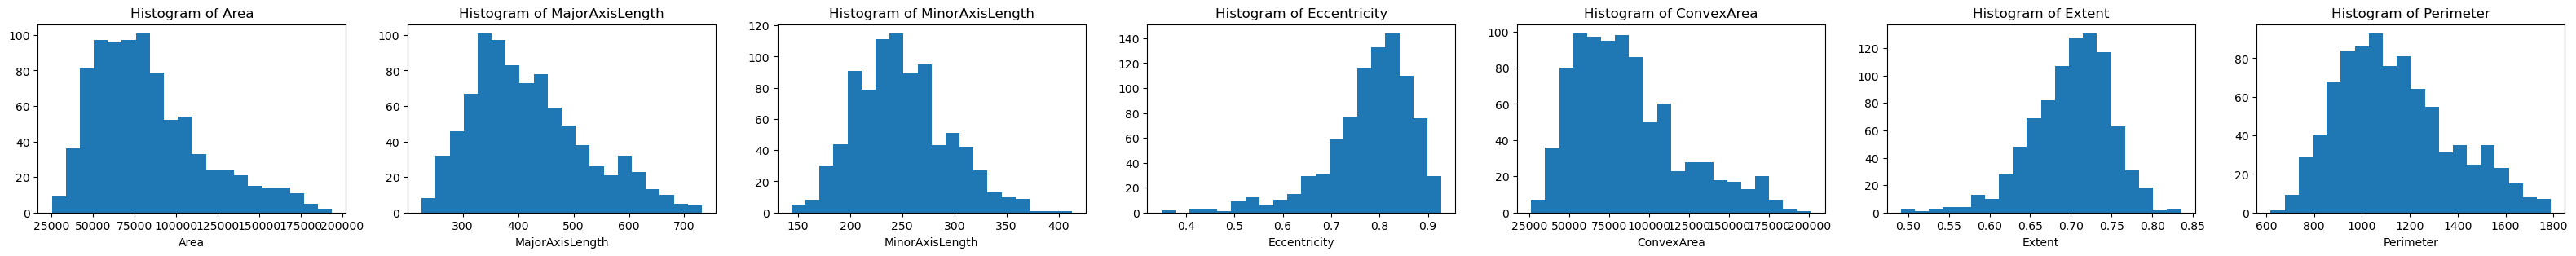

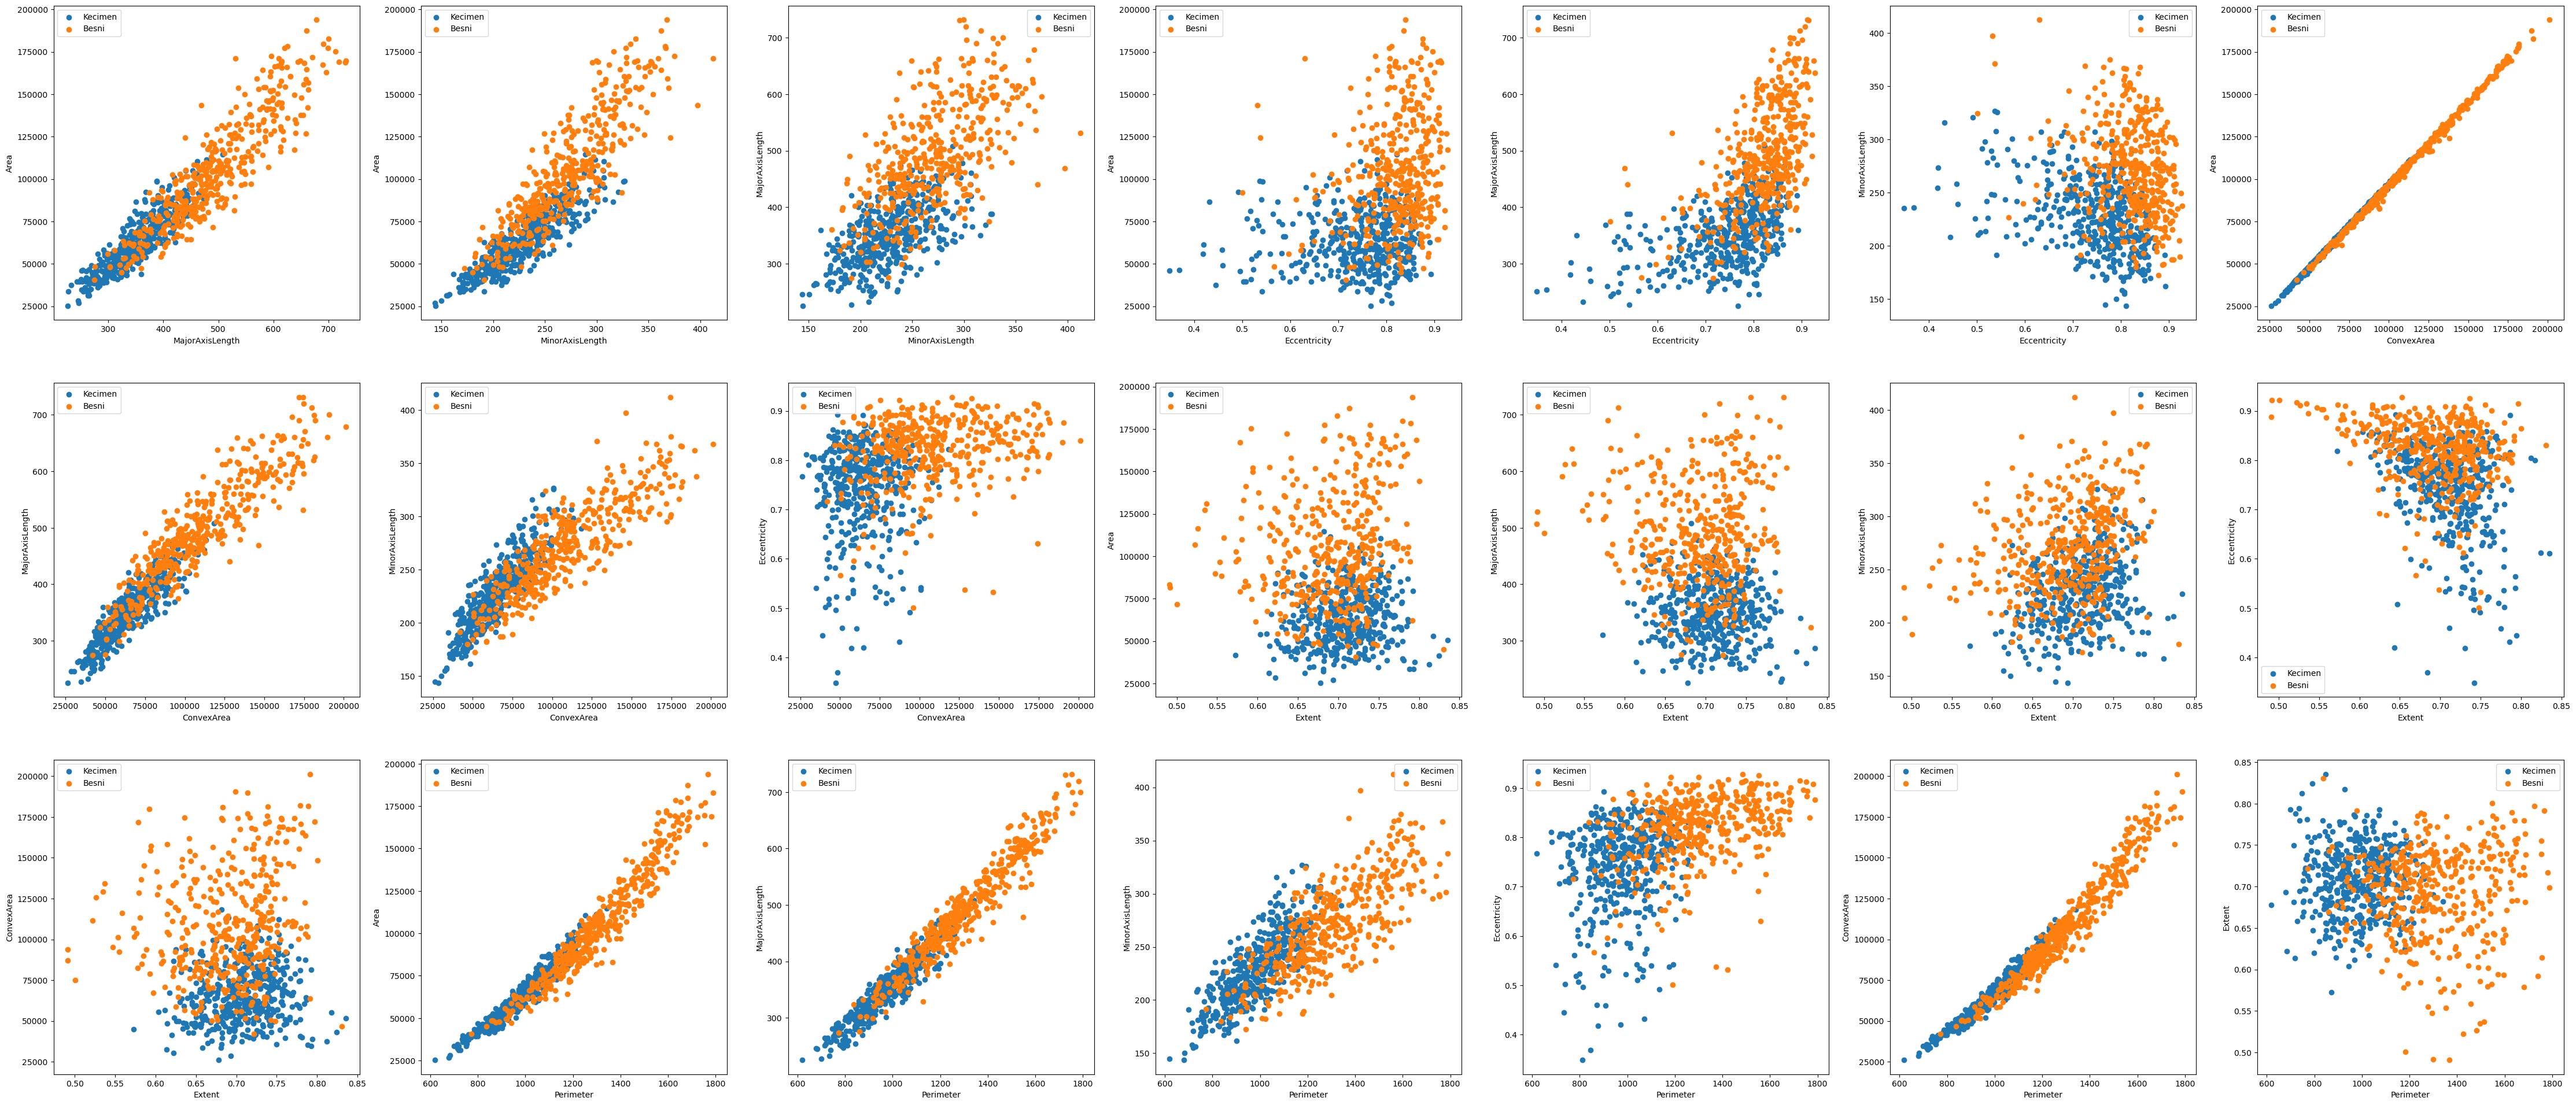

<Figure size 1000x1000 with 0 Axes>

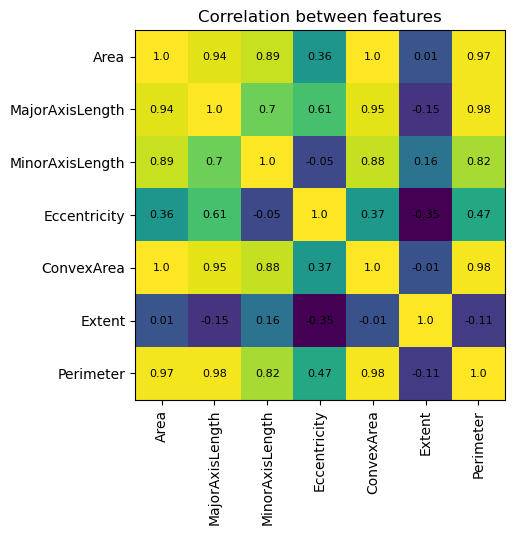

In [62]:
# Visualizing histogram, pairplots and heatmap of features
hist_pair_heat(X, X_header, y)

# Data pre-processing

In [63]:
# Standardize X using StandardScalar
scalar = StandardScaler()
scalar.fit(X.astype(float))
standardized_X = scalar.transform(X)

# Describe basic statistics of standardized_X
summarize_matrix(standardized_X)

Column		Mean		std		Min		25%		Median		75%		Max		dtype			Null_counts	Outlier_counts
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
0         	0.00      	1.00      	-1.76     	-0.75     	-0.19     	0.54      	3.35      	<class 'float'>		0         	25        
1         	-0.00     	1.00      	-1.91     	-0.75     	-0.17     	0.60      	3.06      	<class 'float'>		0         	9         
2         	0.00      	1.00      	-2.42     	-0.72     	-0.09     	0.60      	3.71      	<class 'float'>		0         	9         
3         	0.00      	1.00      	-4.79     	-0.44     	0.20      	0.68      	1.65      	<class 'float'>		0         	42        
4         	0.00      	1.00      	-1.78     	-0.77     	-0.19     	0.56      	3.39      	<class 'float'>		0         	18        
5         	0.00      	1.00      	-4.23     	-0.59     	0.12      	0.68      	2.74      	<cla

In [64]:
#using LabelEncoder to Encode y
encoder = MyEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)
print(np.random.choice(encoded_y, size=5))

"Kecimen" is encoded as 0
"Besni" is encoded as 1
[0 1 1 0 0]


# Split the data into training and testing sets

In [65]:
X_train, X_test, y_train, y_test = TrainTestSplit(standardized_X, encoded_y, train_ratio=0.8)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
print(f"Shape of X_train is {X_train.shape}.\nShape of the X_test is {X_test.shape}")
print(f"Shape of y_train is {y_train.shape}.\nShape of the y_test is {y_test.shape}")

Shape of X_train is (692, 7).
Shape of the X_test is (173, 7)
Shape of y_train is (692, 1).
Shape of the y_test is (173, 1)


# Model training

In [66]:
# Creating MLPClassifier model with 7 input nodes with 1 hidden layer of size 10 and 1 output node
model = MLPClassifierNP(7, [10], 1, seed=None)

# Training the model and collecting metrics at each epoch into history variable
history = model.fit(X=X_train, y=y_train,learning_rate=0.01, epochs=100)

# Model Predictions
predictions = model.predict(X_test)

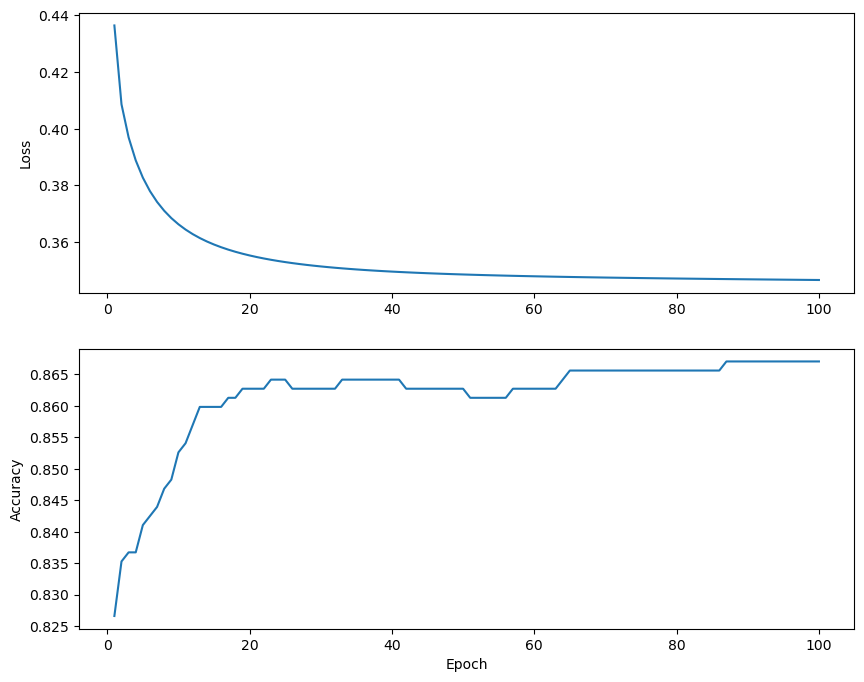

Lowest loss = 0.3467 at epoch 100 and loss at final epoch is 0.3467
Highest accuracy = 0.8671 at epoch 87 and accuracy at final epoch is 0.8671


In [67]:
# Plotting the training loss and accuracy as a function of epoch
history_plot(history)

# Model evaluation

#### Obtaining a more accurate and realiable estimate of model performance using K-fold cross validation.

In [68]:
avg_acc, score = model.k_fold_cross_val_score(X_train, y_train, k=10, learning_rate=0.01, epochs=100, seed=None)
print(f"Accuracies for each fold = {score}")
print(f"Average accuracy of the model = {avg_acc}")


Accuracies for each fold = [0.8261, 0.8696, 0.8841, 0.8986, 0.8841, 0.8261, 0.8406, 0.8406, 0.8696, 0.9014]
Average accuracy of the model = 0.8641


In [69]:
metrics(y_test, predictions)

kesimen_counts = 86
Besni_counts = 87
--------------------------------------------------
		confusion matrix
--------------------------------------------------
		True_Kecimen	True_Besni
Pred_Kecimen	   80		    6
Pred_Besni	   17		   70
--------------------------------------------------
rmse		 =      0.365
r2		 =      0.460
accuracy	 =      0.867
precision	 =      0.921
recall		 =      0.805
f1_score	 =      0.859
NOTE : Precision, Recall, f1_score are calculated by taking besni as positive class


# Reporting:

# Introduction:

This analysis aims to use a Multilayer Perceptron (MLP) Classifier to classify raisin samples into two categories, "Kecimen" and "Besni." The dataset used for this task includes 900 samples, with 450 belonging to each category. Each sample contains 7 input features and 1 label.

# Data Exploration:

In the initial data exploration phase, various metrics were calculated to gain insights into the characteristics of the dataset. Outliers were identified, and it was observed that certain features displayed a high degree of correlation. Since MLP classifiers are not adversely affected by outliers, these features were retained for further analysis.

# Data Preparation:

To prepare the dataset for training the MLP model, the features were scaled using StandardScaler during the preprocessing step. This was done to standardize the scale of all features with mean 0 and standard deviation of 1, which is crucial to improve the performance and stability of machine learning models.

# Model Architecture:

The MLPClassifier is a type of neural network that consists of an input layer, one or more hidden layers, and an output layer. Each layer is made up of multiple nodes, which are also referred to as neurons.
  
  In this case, the input layer of the MLPClassifier has 7 nodes, which corresponds to the 7 input features in the dataset. The hidden layer has 10 nodes, which means that there are 10 neurons that are used to process the input data and compute the output. The output layer has only 1 node, which corresponds to the label that the model is predicting (either Kecimen or Besni).

   The sigmoid function is used as the activation function for the hidden layer and output layer. The sigmoid function maps any input value to a value between 0 and 1, which can be interpreted as a probability. This is useful for classification tasks because it allows the model to output a probability for each possible class label, which can be used to make predictions.
   
   The cross-entropy loss function is used to calculate the error between the predicted label and the true label. This loss function is commonly used for classification tasks and is designed to penalize the model more heavily for incorrect predictions that have a high confidence. is an iterative process that continues until the model has converged to a set of weights that minimize the loss function.

# Model Performance:

The evaluation metrics for the MLPClassifier on the Raisin dataset are good, with an accuracy score of 0.873 indicating that the model correctly classified 87.3% of the samples. The precision score of 0.901 shows that the model correctly predicted 90.1% of the Kecimen samples out of all the samples it predicted as Kecimen. The recall score of 0.839 indicates that the model correctly identified 83.9% of the Kecimen samples out of all the actual Kecimen samples. The F1-score of 0.869, which is a weighted average of precision and recall, suggests that the model performed well overall and is a good measure to evaluate the model's performance.

Although the model has demonstrated good performance in classifying Kecimen and Besni samples, its performance can be further improved by tuning the hyperparameters such as the learning rate, number of hidden layers, and number of nodes in the hidden layers. Additionally, exploring other models and techniques can also potentially improve the model's performance. It is important to note that the evaluation of the model's performance should be done with caution, and the model's performance on unseen data should be tested to ensure its effectiveness in real-world scenarios.

# Conclusion:

The MLP model trained on the Raisin dataset was able to classify samples into Kecimen and Besni with a high degree of accuracy, precision, and recall. The model can be used to classify new samples into Kecimen or Besni based on their features. The standardization of features and the choice of MLPClassifier algorithm helped in achieving the desired accuracy and F1-score. Further analysis can be done by exploring other algorithms and hyperparameter tuning to improve the performance of the model.